# STOCK/CRPYTO PRICE PREDICTION MODEL

## The following code is an example on how to use simple data analysis tolls in order to set up a simple strategy for long and short term financial trading

### We will make use of the programing language python (3.x) which suits nicely for data anlysis

## --> This a very is simplified model for trading. One should always invest just as much money as one can afford to loose and do own studies in advance. 

## Required modules:
- numpy: the code is designed to be vectorized such that the numpy module can be used and calculations performed fast
- pandas: module for illustrative data frames
- yfinance: api module provided by yahoo finance to get current and previous asset prices
- matplotlib: (sub)module(s) for plots
- scipy: (sub)module for statistical and signal analysis
- datetime: (optional)

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy.signal import argrelextrema
import scipy.stats
import datetime

## Define functions: 

In [2]:
def download_data(ticker, timestamp='Close', *args, **kwargs):
    '''
    Function to download data from yahoo finance. 
    Inputs: 
        - ticker: asset of interest. Name has to be concise with yahoo finance. 
        - timestamp: datetime of evaluation.
            default: Close, i.e. closing prices of asset
            It is important to note, even if today's market is open (and not yet closed), 
            the last value in 'Close' will be the current value of the asset by the time of downloading.
        - additional arguments and keywords, 
            i.e. *args, **kwargs that will be passed to the yfinance function for downloading
    Outputs:
        - pandas.core.series.Series, i.e. prices of the asset at the specified timestamp.
    '''
    return yf.download(ticker, *args, **kwargs)[timestamp]

def calc_EMA(data, average_sample):
    '''
    Function to calculate the exponential moving average
    Inputs:
        - average_sample: number of days to average
    Outputs:
        - pandas.core.series.Series, i.e. ema prices.
    '''
    return data.ewm(span=average_sample, adjust=False).mean()
 
def price_model(data, values_of_interest=(12, 26, 9), buy_delay=1, grad_return=True):
    '''
    Function to set up the price model. The idea is to locate the inflection points of the difference of
    "moving average converging diverging (MACD)" and "Signal Line (Signal_Line)". These indicate local up and down
    trends. The actual buy and sell prices are therefore the next day, i.e. buy_delay
    Inputs: 
        - data: asset prices
        - values_of_interest: days to calculate the MACD (first two values) and Signal Line (last value). 
            default: 12, 26, 9
        - buy_delay: buy and sell dates
            default: 1
        - grad_return: return the "gradient" of the model, i.e. the model itself
            default: True
    Outputs:
        - local_min: Buy prices
        - local_max: Sell prices
        - grad: "gradient" of the model (optionally)
    '''
    MACD = calc_EMA(data, values_of_interest[0]) - calc_EMA(data, values_of_interest[1])
    Signal_Line = calc_EMA(MACD, values_of_interest[2])
    grad = np.gradient(MACD - Signal_Line)
    local_min = argrelextrema(grad, np.less)[0]
    local_max = argrelextrema(grad, np.greater)[0]
    try:
        if local_max[0] < local_min[0]:
            local_max = local_max[1:]    
    except IndexError:
        pass
    #this will be handled later!
        #case where one has one sell data without a buy data
    
    if grad_return:
        return local_min + buy_delay, local_max + buy_delay, grad
    else:
        return local_min + buy_delay, local_max + buy_delay

def evaluate_price_model(data, locs_and_grad, entry_money=1000, fees=(1.005, .995), tax=.75, df_return=True, visualize=False, *args, **kwargs):
    '''
    Function to evaluate the price model predictions
    Inputs:
        - data: price data of asset
        - locs: buy and sell locations, i.e. return from from function price_model()
        - entry_money: initial investment
            default = 100
        - fees: fee for buying and selling prices, i.e. buy asset at broker for slightly higher price than actual asset prices, vice versa for sells
            default = (1.005, .995), i.e. .5% higher buy price and .5% lower sell price
        - tax: german tay payments for annual wins > 800€
            default = .75, i.e. 25%
        - df_return: return model evaluation as pandas DataFrame
            default = True
    Outputs:
        - net_income: Net Income/win after entry_money (and possibly tax) subtracted
        - df_return: model evaluation as pandas DataFrame
    '''
    try:
        ticker=kwargs['ticker']
    except KeyError:
        ticker='Unknown'
    print_opening(ticker=ticker, start_date = data.index[0].strftime('%D'), \
                  end_date = data.index[-1].strftime('%D'), \
                  initial_investment = entry_money)
    if locs_and_grad is None:
        return
    buy_locs, sell_locs = locs_and_grad[0:2]
    if buy_locs.shape[0] > sell_locs.shape[0]:
        print('[INFO]: There is currently an open position to be sold in the future.')
    elif buy_locs.shape[0] < sell_locs.shape[0]:
        print('[INFO]: First sell location will not be displayed!')
        try:
            sell_locs[0] = buy_locs[0]
        except IndexError:
            print('[INFO]: No buy locations occured. Sell locations are set to buy locations')
            sell_locs = buy_locs
        
    buy_prices = data[buy_locs]
    buy_dates = data.index.values[buy_locs]
    sell_prices = data[sell_locs]
    sell_dates = data.index.values[sell_locs]
    #Include fees
    buy_prices *= fees[0]
    sell_prices *= fees[1]
    #Initialize arrays
    number_of_calls = sell_prices.shape[0]
    if buy_prices.shape > sell_prices.shape:
        #must use to_numpy() since the dates are still stored in prices as names 
        #-> pandas devides same dates, obviously buy and sell dates differ, 
        #hence pandas would return NaN all the time
        ratios = sell_prices.to_numpy() / buy_prices.to_numpy()[:-1]
    else:
        ratios = sell_prices.to_numpy() / buy_prices.to_numpy()
    trade_rewards = entry_money * np.cumprod(ratios)
    #Calculate trade wins
    trade_wins = np.diff(trade_rewards)
    #Insert first win
    try:
        trade_wins = np.insert(trade_wins, 0, trade_rewards[0] - entry_money)
    except IndexError:
        #case where one has one buy but not yet selled.
        pass
    #Evaluate Calls
    good_calls = np.where(trade_wins > 0)
    bad_calls = np.where(trade_wins < 0)
    tax_pays = trade_wins[good_calls] * tax
    try:
        efficiency = good_calls[0].shape[0] / number_of_calls
    except ZeroDivisionError:
        efficiency = np.nan
    #TODO: Error handling here:
    win_loss = trade_wins / (trade_rewards - trade_wins)
    average_win = win_loss[np.where(win_loss > 0)].mean()
    average_loss = win_loss[np.where(win_loss < 0)].mean()
    
    #net_income = trade_rewards[-1] - np.sum(tax_pays) - entry_money
    #That is the same?!
    if np.sum(trade_wins) > 800:
        print('[INFO]: {:.2f} tax was paid.'.format(np.sum(trade_wins) * (1 - tax)))
        #Pay taxes every time ? 
        net_income = np.sum(trade_wins) - np.sum(tax_pays)
        #Else pay taxes after last sell
        net_income = (trade_rewards[-1] - entry_money) * tax
    else:
        print('[INFO]: No tax paid. (win < 800)!')
        net_income = np.sum(trade_wins)
    #create final DataFrame
    #be aware that buy_dates can be 1 entry longer then sell dates!
    if buy_dates.shape[0] > sell_dates.shape[0]:
        if sell_dates.shape[0] > 0:
            print('[INFO]: Last entry of "Sell Dates" will be assigned equally as the penultimate one.')
            sell_dates = np.append(sell_dates, sell_dates[-1])
        else:
            print('[INFO]: First entry of "Sell Dates" will be first entry of "Buy Dates".')
            sell_dates = buy_dates[0]
        try:
            sell_prices.loc[pd.Timestamp.max] = np.nan
        except: #NOT WORKING? OverflowError:
            sell_prices.loc[buy_prices.index[-1]] = np.nan
        trade_rewards = np.append(trade_rewards, np.nan)
        trade_wins = np.append(trade_wins, np.nan)
    final_df = pd.DataFrame(data = {'Buy Dates': buy_dates, 'Sell Dates': sell_dates, \
                                    'Buy Prices': buy_prices.to_numpy(), 'Sell Prices': sell_prices.to_numpy(), \
                                    'Trade Reward': trade_rewards, 'Trade Win': trade_wins})
    print('*'*80)
    print('[SUMMARY]: Average trade win: {:.10%}'.format(average_win))
    print('[SUMMARY]: Average trade loss: {:.10%}'.format(average_loss))
    if efficiency == 1:
        print('[SUMMARY]: Perfect Model --> Zero Bad Calls')
    else:
        print('[SUMMARY]: Efficiency: {:.2%}'.format(efficiency))
    print('[SUMMARY]: NET WIN: {:.2f}'.format(net_income))
    print('*'*80)
    print('FINAL BUY/SELL HISTORY:')
    print(final_df)
    print('*'*80)
    if visualize:
        print('[INFO]: "visualize" is active --> no returns for this function')
        try:
            grad = locs_and_grad[2]
            plot_model(final_df, data, grad, (buy_locs, sell_locs))
        except IndexError:
            print('[ERROR]: plot_model() not possible. Input "grad" is not passed/available!')
    else:
        if df_return:
            return net_income, final_df
        else:
            return net_income
        
def compute_break_value(data, refactor_step_size=1, do_model=False, data_return=False):
    today_value_avail = pd.Timestamp.today().normalize() in data.index
    #ATTENTION: IF LAST ENTRY OF DATA IS NOT YESTERDAY (e.g. OVER WEEKENDS WHEN MARKETS ARE CLOSED), 
    #ONE CAN GET AN INTERPOLATED VALUE FOR SELL PRICE IN THE MODEL DATAFRAME!
    if today_value_avail:
        imag_data = pd.DataFrame.copy(data, deep=True)
        imag_new_day = imag_data.index[-1]
    else:
        imag_new_day = pd.date_range(pd.Timestamp.today(), periods = 1, normalize=True)
        imag_days = data.index.append(imag_new_day)
        imag_data = pd.Series('NaN', index=imag_days)
        imag_data[data.index] = data.values
    #create a price range with 50% deviation of the last one.
    deviation = .5
    start_value = (data.tail(1).values * (1 - deviation))
    end_value = (data.tail(1).values * (1 + deviation))
    step_size = (end_value / start_value) * refactor_step_size
    rng = np.arange(start_value, end_value, step_size)
    #start algorithm
    first_break_values, second_break_value = None, None
    for imag_close in rng:
        imag_data[imag_new_day] = imag_close
        imag_locs_and_grad = price_model(imag_data)
        imag_grad = imag_locs_and_grad[-1]
        if np.sign(np.diff(imag_grad)[-1]) > 0 and second_break_value is None:
            second_break_value = imag_close
            print("Today's break value: {}".format(second_break_value))
        elif np.sign(np.diff(imag_grad)[-2]) > 0 and first_break_values is None:
            first_break_values = imag_close
            print("Yesterday's break value: {}".format(first_break_values))
        if all([first_break_values, second_break_value]):
            break
    if first_break_values < second_break_value:
        imag_close = first_break_values
    else:
        imag_close = second_break_value
    imag_data[imag_new_day] = rng[np.where(rng == imag_close)[0] - 1]
    print('Current Value: {}'.format(data.values[-1]))
    tolerance = np.abs(imag_close - data.values[-1])
    print('Tolerance: {}'.format(tolerance))
    #assign to imag_data
    imag_data[imag_new_day] = rng[np.where(rng == imag_close)[0] - 1]
    if do_model:
        imag_locs_and_grad = price_model(imag_data)
        evaluate_price_model(imag_data, locs_and_grad=imag_locs_and_grad, visualize=True, ticker='IMAGINARY DATA')
    elif data_return:
        return imag_data
    else:
        return second_break_value, first_break_values, tolerance
    
def plot_model(model, data, grad, locs, start=None):
    '''
    Function to plot a model.
    Inputs:
        - model: price model
        - data: asset prices
        - grad: "gradient" of price model
        - locs: "locations" of price model
    '''
    if start is None:
        index_range = data.index
    else:
        pass
    plt.figure(figsize=(16, 9))
    ax1 = plt.subplot(2, 1, 1)
    plt.fill_between(data.index, 0, grad, where=grad>0, facecolor='green', interpolate=True)
    plt.fill_between(data.index, 0, grad, where=grad<=0, facecolor='red', interpolate=True)
    plt.vlines(data.index[locs[1] - 1], np.min(grad), np.max(grad), color='r')
    plt.vlines(data.index[locs[0] - 1], np.min(grad), np.max(grad), color='g')
    plt.legend(['Up Trend', 'Down Trend', 'Peak Reached', 'Min Reached'])
    plt.grid()
    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    plt.plot(data)
    plt.vlines(model['Sell Dates'], np.min(data), np.max(data), color='r')
    plt.vlines(model['Buy Dates'], np.min(data), np.max(data), color='g', linestyle='--')
    plt.legend(['Price', 'Sell Dates', 'Buy Dates'])
    plt.grid()
    plt.show()
    
def print_opening(*args, **kwargs):
    '''
    Function to print opening of algorithm.
    Inputs:
        - args and kwargs: both will be printed, but "_" in args will be replaced by " ".
    '''
    n_break_chars = 82
    print('-' * n_break_chars)
    header = ['PRICE MODEL']
    version = ['Version 0.2']
    copyright = ['Authors: Marco Rosenzweig & Patrick Lorenz']
    for text in [header, version, copyright]:
        print(next(map(_format_string, text)))
    print('-' * n_break_chars)
    for arg, kwarg in kwargs.items():
        arg = arg.replace('_', ' ')
        if not isinstance(kwarg, str):
            kwarg = str(kwarg)
        text = [(' = ').join([arg, kwarg])]
        print(next(map(_format_string, text)))
    print('-' * n_break_chars)
    print()
    
def print_closing(*args, **kwargs):
    '''
    Function to print closing of algorithm.
    Inputs:
        - args and kwargs: both will be printed, but "_" in args will be replaced by " ".
    '''
    n_break_chars = 82
    print('-' * n_break_chars)
    
def _format_string(string, center_alligned=True):
    '''
    Internal function used for print_opening and print_closing
    '''
    special_char = '|'
    if center_alligned:
        string = string.center(80)
    return '{}{}{}'.format(special_char, string, special_char)
    
def calc_z_value(data, tolerance, sampling_points=30):
    diff = np.abs(np.diff(data[-sampling_points:]))
    diff_df = pd.DataFrame(data={'Price Movement': diff})
    print(diff_df.describe())
    z = (tolerance - diff.mean()) / diff.std()
    print()
    print('--> Chance for overshooting tolerance: {:.2%}'.format(1 - scipy.stats.norm.cdf(z)))

# MAIN CODE

## Download closing prices from yahoo finance

In [3]:
ticker = 'BTC-USD'
data = download_data(ticker, start='2020-01-01')
print('Current value: {}'.format(data.values[-1]))

[*********************100%***********************]  1 of 1 completed
Current value: 6831.63037109375


## model prices and evaluate price model

----------------------------------------------------------------------------------
|                                  PRICE MODEL                                   |
|                                  Version 0.2                                   |
|                   Authors: Marco Rosenzweig & Patrick Lorenz                   |
----------------------------------------------------------------------------------
|                                ticker = BTC-USD                                |
|                             start date = 12/31/19                              |
|                              end date = 04/11/20                               |
|                            initial investment = 200                            |
----------------------------------------------------------------------------------

[INFO]: No tax paid. (win < 800)!
********************************************************************************
[SUMMARY]: Average trade win: 5.7925312063%
[SUMMARY]:

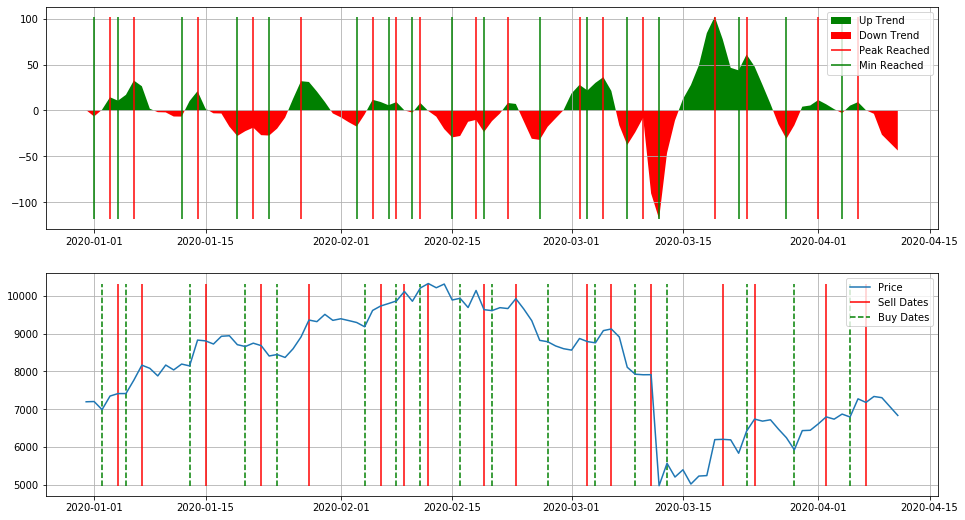

In [4]:
locs_and_grad = price_model(data)
evaluate_price_model(data, locs_and_grad=locs_and_grad, ticker=ticker, visualize=True, entry_money=200)

In [5]:
break_value_01, break_value_02, tolerance = compute_break_value(data)

Today's break value: 7375.815185546875
Yesterday's break value: 7546.815185546875
Current Value: 6831.63037109375
Tolerance: 544.184814453125


In [8]:
calc_z_value(data, tolerance)

       Price Movement
count       29.000000
mean       249.843363
std        226.121110
min          7.585449
25%         60.237305
50%        191.948730
75%        363.340820
max        952.754395

--> Chance for overshooting tolerance: 9.26%


# Final remarks

In [9]:
data = download_data('BTC-EUR', start='2020-01-01', end='2020-04-10', interval='60m')
data.head(10)

[*********************100%***********************]  1 of 1 completed


Datetime
2019-12-31 23:00:00+00:00    6413.315918
2020-01-01 00:00:00+00:00    6418.653320
2020-01-01 01:00:00+00:00    6451.124023
2020-01-01 02:00:00+00:00    6474.983887
2020-01-01 03:00:00+00:00    6461.127930
2020-01-01 04:00:00+00:00    6459.584473
2020-01-01 05:00:00+00:00    6462.758789
2020-01-01 06:00:00+00:00    6443.095703
2020-01-01 07:00:00+00:00    6426.454102
2020-01-01 08:00:00+00:00    6413.435547
Name: Close, dtype: float64

In [10]:
incomes = np.empty(24)
for time in range(24):
    current_time = pd.Timestamp(2020, 1, 1, time)
    try:
        rng = pd.date_range(start=current_time, end=pd.Timestamp(2020, 4, 10), freq='d', tz='Europe/London', name='Datetime')
    except:
        incomes[time] = np.nan
        continue
    try:
        test_data = data.loc[rng]
        locs_and_grad = price_model(test_data)
        incomes[time] = evaluate_price_model(test_data, locs_and_grad=locs_and_grad, entry_money=1000, ticker=ticker, visualize=False)[0]
    except:
        incomes[time] = np.nan

----------------------------------------------------------------------------------
|                                  PRICE MODEL                                   |
|                                  Version 0.2                                   |
|                   Authors: Marco Rosenzweig & Patrick Lorenz                   |
----------------------------------------------------------------------------------
|                                ticker = BTC-USD                                |
|                             start date = 01/01/20                              |
|                              end date = 04/09/20                               |
|                           initial investment = 1000                            |
----------------------------------------------------------------------------------

[INFO]: There is currently an open position to be sold in the future.
[INFO]: 322.28 tax was paid.
[INFO]: Last entry of "Sell Dates" will be assigned equally as the pen

----------------------------------------------------------------------------------
|                                  PRICE MODEL                                   |
|                                  Version 0.2                                   |
|                   Authors: Marco Rosenzweig & Patrick Lorenz                   |
----------------------------------------------------------------------------------
|                                ticker = BTC-USD                                |
|                             start date = 01/01/20                              |
|                              end date = 04/09/20                               |
|                           initial investment = 1000                            |
----------------------------------------------------------------------------------

[INFO]: 410.33 tax was paid.
********************************************************************************
[SUMMARY]: Average trade win: 9.4817039652%
[SUMMARY]: Aver

14   2207.187148  145.390202  
********************************************************************************
----------------------------------------------------------------------------------
|                                  PRICE MODEL                                   |
|                                  Version 0.2                                   |
|                   Authors: Marco Rosenzweig & Patrick Lorenz                   |
----------------------------------------------------------------------------------
|                                ticker = BTC-USD                                |
|                             start date = 01/01/20                              |
|                              end date = 04/09/20                               |
|                           initial investment = 1000                            |
----------------------------------------------------------------------------------

[INFO]: 353.55 tax was paid.
****************************

----------------------------------------------------------------------------------
|                                  PRICE MODEL                                   |
|                                  Version 0.2                                   |
|                   Authors: Marco Rosenzweig & Patrick Lorenz                   |
----------------------------------------------------------------------------------
|                                ticker = BTC-USD                                |
|                             start date = 01/01/20                              |
|                              end date = 04/09/20                               |
|                           initial investment = 1000                            |
----------------------------------------------------------------------------------

[INFO]: 224.83 tax was paid.
********************************************************************************
[SUMMARY]: Average trade win: 5.1888904184%
[SUMMARY]: Aver

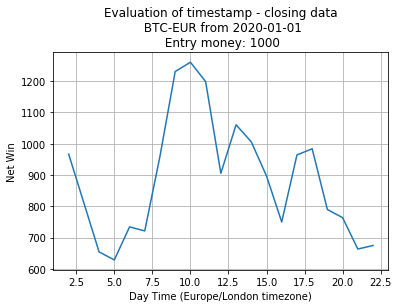

In [11]:
plt.plot(incomes)
plt.title('Evaluation of timestamp - closing data\n BTC-EUR from 2020-01-01\n Entry money: 1000')
plt.ylabel('Net Win')
plt.xlabel('Day Time (Europe/London timezone)')
plt.grid()
plt.show()

In [ ]:
#THIS WON'T WORK:

In [ ]:
years = np.arange(2000, 2020, 1)
ticker_list = ['ETC-USD', 'BTC-USD', 'LTC-USD', 'XRP-USD', 'BCH-USD']
ticker_list = ['TSLA', 'AAPL', 'BYND', 'NFLX', 'SPOT']
win_loss = np.zeros([len(ticker_list), years.shape[0], 2])
for n_ticker, ticker in enumerate(ticker_list):
    for n_year, year in enumerate(years):
        current_year = pd.Timestamp(year, 1, 1)
        data = download_data(ticker, start=current_year)
        locs_and_grad = price_model(data)
        win_loss[n_ticker][n_year] = evaluate_price_model(data, locs_and_grad=locs_and_grad, ticker=ticker, visualize=False, entry_money=200)
safety_factors = np.divide(win_loss[:, :, 0], np.abs(win_loss[:, :, 1]))

In [ ]:
plt.figure(figsize=(16, 9))
ax1 = plt.subplot(3, 1, 1)
plt.title('Price model of crypto assets until today.', fontsize=15)
for n_ticker, ticker in enumerate(ticker_list):
    plt.plot(years, win_loss[n_ticker, :, 0] * 100)
plt.xticks(fontsize=0)
ax1.yaxis.tick_right()
plt.yticks(fontsize=12)
plt.ylabel('Average Trade Win [%]', fontsize=12)
plt.grid()
plt.legend(ticker_list)
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
for n_ticker, ticker in enumerate(ticker_list):
    plt.plot(years, win_loss[n_ticker, :, 1] * 100)
ax2.invert_yaxis()
ax2.yaxis.tick_right()
plt.yticks(fontsize=12)
plt.ylabel('Average Trade Loss [%]', fontsize=12)
plt.grid()
plt.xticks(fontsize=0)
ax3 = plt.subplot(3, 1, 3, sharex=ax1)
for n_ticker, ticker in enumerate(ticker_list):
    plt.plot(years, safety_factors[n_ticker])
plt.yticks(fontsize=12)
plt.ylabel('Safety Factor [-]', fontsize=12)
ax3.yaxis.tick_right()
plt.yticks(fontsize=12)
plt.xlabel('Start year of price model', fontsize=15)
plt.xticks(fontsize=14)
plt.grid()
plt.savefig('OUTPUT/STOCK_ASSET_NEW.pdf')

In [ ]:
download_data(ticker_list)